In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


In [12]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation, OtherFeaturePerturbation
from teren.utils import get_random_activation

In [20]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, reduce=True):

    base_f_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: base_f_acts[feature_idx] for feature_idx in range(base_f_acts.shape[0]) if base_f_acts[feature_idx] / base_f_acts.max() > thresh}

    random_features = {feature_idx: base_f_acts[feature_idx] for feature_idx in random.sample(range(base_f_acts.shape[0]), 20) if base_f_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = base_f_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = base_f_acts[min_dot]
            print(min_dot)

    sorted_base_features = sorted(active_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    base_results = defaultdict(defaultdict)
    target_results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        print(
            f"Base Recon Error: {(sae.decode(sae.encode(exp_ref.act)) - exp_ref.act).abs().sum()}"
        )
        print(
            f"Target Recon Error: {(sae.decode(sae.encode(target)) - target).abs().sum()}"
        )

        target_f_acts = sae.encode(target)[0, -1, :]
        target_features = {feature_idx: target_f_acts[feature_idx] for feature_idx in range(target_f_acts.shape[0]) if target_f_acts[feature_idx] / target_f_acts.max() > thresh}
        sorted_target_features = sorted(target_features.items(), key=operator.itemgetter(1))

        print(f"Using {len(target_features.keys())} target active features: {target_features}")
        
        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        print(sae.encode(target).shape)
        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)
        
        for i in range(len(sorted_base_features)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, sorted_base_features[i], target_f_acts[sorted_base_features[i][0]], dataset, sae)
            base_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            base_results[sorted_base_features[i][0]]['kl_div'] = base_kl_div

        for j in range(len(sorted_target_features)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, sorted_target_features[j], base_f_acts[sorted_target_features[j][0]], dataset, sae)
            target_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            target_results[sorted_target_features[j][0]]['kl_div'] = target_kl_div

        base_feature_activation = torch.Tensor([feature[1] for feature in sorted_base_features])
        for i, feature in enumerate(sorted_base_features):
            base_results[feature[0]]['Feature Activation'] = base_feature_activation[i]

        target_feature_activation = torch.Tensor([feature[1] for feature in sorted_target_features])
        for i, feature in enumerate(sorted_target_features):
            target_results[feature[0]]['Feature Activation'] = target_feature_activation[i]

    return base_results, target_results, control, sae_control


In [29]:
def plot_results(fig, ax, base_results, target_results, control, sae_control):

    i = 0
    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for f_idx in base_results.keys():
        print(base_results[f_idx]['kl_div'].min())
        ax[i][0].plot(base_results[f_idx]['kl_div'], color='green', linewidth=0.5)
        ax[i][1].plot(base_results[f_idx]['kl_div'], color='green', linewidth=0.5)
        ax[i][2].plot(np.log10(base_results[f_idx]['kl_div']), color='green', linewidth=0.5)

    for f_idx in target_results.keys():
        print(target_results[f_idx]['kl_div'].min())
        ax[i][0].plot(target_results[f_idx]['kl_div'], color='yellow', linewidth=0.5)
        ax[i][1].plot(target_results[f_idx]['kl_div'], color='yellow', linewidth=0.5)
        ax[i][2].plot(np.log10(target_results[f_idx]['kl_div']), color='yellow', linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0, 361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0, 361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0, 180)
    #ax[i][2].set_ylim(-0.01, 2)
    

In [25]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 1
    base_results, target_results, controls, sae_controls = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, reduce=True)

    if i == 0:     
        all_base_results = base_results  
        all_target_results = target_results                             
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for f_idx, result in base_results.items():
            all_base_results[f_idx]['kl_div'] = result

        for f_idx, result in target_results.items():
            all_target_results[f_idx]['kl_div'] = result

        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 393,  661,  351, 9136, 5076, 2761, 2107,  612,   13,  198]])
Prompt:  or people with substance abuse problems live there.

12757
2055
12757
12757
12757
24189
12757
12757
12757
12757
12757
12757
12757
12757
12757
12757
12757
12757
12757
12757
20446
12757
12757
12757
5807
12757
12757
12757
12757
12757
22864
12757
12757
12757
12757
12757
12757
12757
Using 38 active features: {147: tensor(7.4778), 594: tensor(3.9958), 813: tensor(5.5524), 2838: tensor(4.1669), 3052: tensor(2.8555), 4012: tensor(2.1548), 4238: tensor(9.5361), 4948: tensor(2.7742), 5189: tensor(2.3600), 5264: tensor(2.6254), 5993: tensor(1.7639), 6051: tensor(4.8391), 6229: tensor(3.2397), 6344: tensor(2.5431), 6941: tensor(3.2388), 7218: tensor(2.5533), 7467: tensor(3.9889), 9549: tensor(3.0160), 9965: tensor(14.0905), 10480: tensor(2.0146), 11741: tensor(1.4516), 12358: tensor(3.3985), 12654: tensor(4.0954), 14740: tensor(2.9329), 15017: tensor(1.4115), 15117: tensor(1.8136), 15221: tensor(5.6924), 15900: tensor(

Base Recon Error: 950.1709594726562
Target Recon Error: 129.353515625
Using 3 target active features: {4628: tensor(21.8801), 15017: tensor(5.6458), 17359: tensor(7.0616)}
torch.Size([1, 1, 24576])
Base Recon Error: 950.1709594726562
Target Recon Error: 129.353515625


100%|██████████| 1/1 [00:24<00:00, 24.59s/it]


tensor(-1.6628e-07)
tensor(-2.3192e-07)
tensor(-2.8851e-07)
tensor(-2.4503e-07)
tensor(-2.1353e-07)
tensor(-2.7283e-07)
tensor(-2.1465e-07)
tensor(-2.7208e-07)
tensor(-2.0084e-07)
tensor(-3.1237e-07)
tensor(-2.6853e-07)
tensor(-4.1044e-07)
tensor(-2.7426e-07)
tensor(-2.9914e-07)
tensor(-3.4657e-07)
tensor(-3.3103e-07)
tensor(-2.8084e-07)
tensor(-4.1698e-07)
tensor(-3.2410e-07)
tensor(-2.9745e-07)
tensor(-2.2614e-07)
tensor(-3.2973e-07)
tensor(-2.2758e-07)
tensor(-1.4140e-07)
tensor(-2.6796e-07)
tensor(-1.5853e-07)
tensor(-3.3407e-07)
tensor(-2.1774e-07)
tensor(-1.7532e-07)
tensor(-3.0036e-07)
tensor(-3.4251e-07)
tensor(-1.3687e-07)
tensor(-2.9079e-07)
tensor(-3.0996e-07)
tensor(-2.9210e-07)
tensor(-1.9386e-07)
tensor(-2.5452e-07)
tensor(-2.1645e-07)
tensor(-2.0309e-07)
tensor(-2.2242e-07)
tensor(-2.8271e-07)


/tmp/ipykernel_11674/4153882002.py:16: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(base_results[f_idx]['kl_div']), color='green', linewidth=0.5)
/tmp/ipykernel_11674/4153882002.py:22: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(target_results[f_idx]['kl_div']), color='yellow', linewidth=0.5)


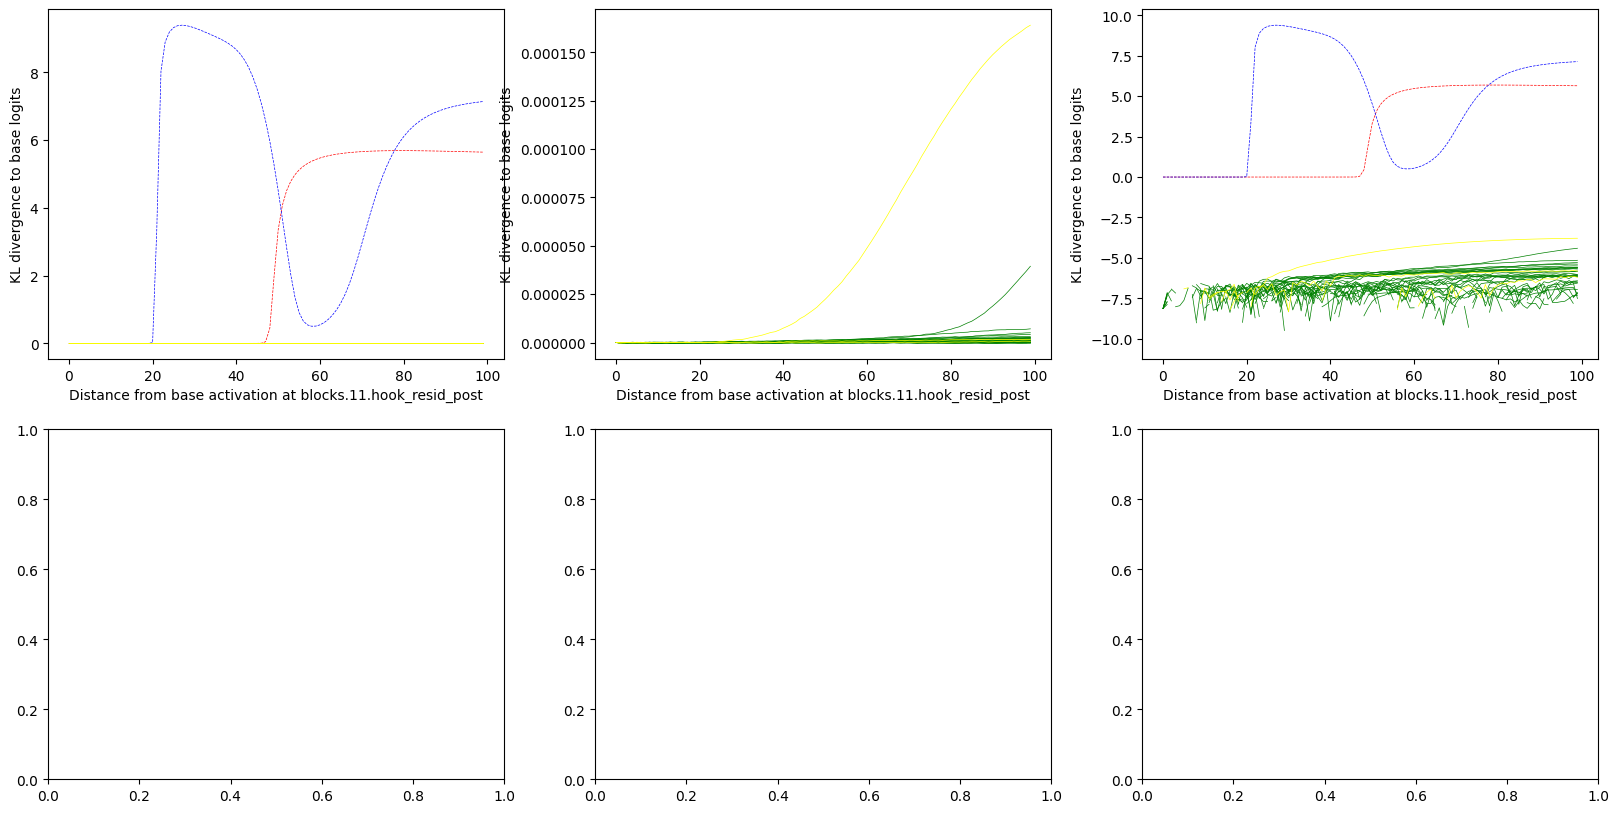

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

plot_results(fig, ax, all_base_results, all_target_results, all_controls, all_sae_controls)
fig.show()

In [ ]:
def plot_all_results(fig, ax, base_results, target_results, control, sae_control, properties):
    
    base_colors = plt.cm.viridis(np.linspace(0,1,len(base_results.keys())))
    target_colors = plt.cm.plasma(np.linspace(0,1,len(target_results.keys())))
    i = 0
    color_property = "Feature Activation"

    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        #ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        #ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    base_plot_order = sorted(base_results.items(), key = lambda item: item[1][color_property])
    target_plot_order = sorted(target_results.items(), key = lambda item: item[1][color_property])

    for j, (feature_idx, data) in enumerate(base_plot_order):
        kl_div = data['kl_div']
        ax[i][0].plot(kl_div, color=base_colors[j], linewidth=0.5)
        ax[i][1].plot(kl_div, color=base_colors[j], linewidth=0.5)
        ax[i][2].plot(np.log10(kl_div), color=base_colors[j], linewidth=0.5)

    for j, (feature_idx, data) in enumerate(target_plot_order):
        kl_div = data['kl_div']
        ax[i][0].plot(kl_div, color=target_colors[j], linewidth=0.5)
        ax[i][1].plot(kl_div, color=target_colors[j], linewidth=0.5)
        ax[i][2].plot(np.log10(kl_div), color=target_colors[j], linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0,361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0,361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0,75)
    #ax[i][2].set_ylim(-0.01,2)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
    cbar = fig.colorbar(sm, ax=ax[i][2])
    cbar.set_label(color_property)
    

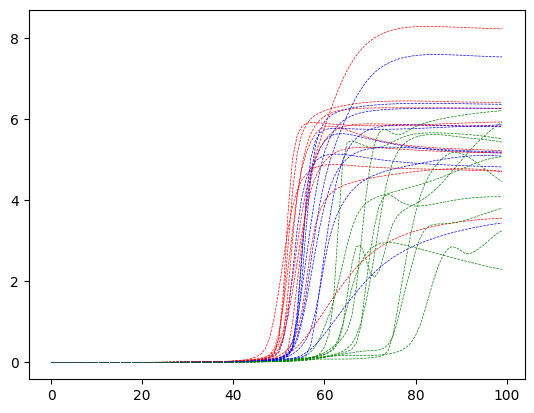

In [24]:
for i in range(n_control):
    plt.plot(all_controls[i][0], color='red', linestyle='--', linewidth=0.5)
    plt.plot(all_sae_controls[i][0], color='blue', linestyle='--', linewidth=0.5)
    plt.plot(all_syns[i][0], color='green', linestyle='--', linewidth=0.5)